<a href="https://colab.research.google.com/github/Htetmin5235/myfirstproject/blob/master/LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [0]:
pd.set_option("display.width", 70)

In [0]:
data = pd.read_csv("SolarPrediction.csv")

In [0]:
data["Time"] = (pd
.to_datetime(data["UNIXTime"], unit="s", utc=True)
.dt.tz_convert("Pacific/Honolulu")).dt.time
data["TimeSunRise"] = (pd
.to_datetime(data["TimeSunRise"],
infer_datetime_format=True)
.dt.time)
data["TimeSunSet"] = (pd
.to_datetime(data["TimeSunSet"],
infer_datetime_format=True)
.dt.time)
data = data.rename({"WindDirection(Degrees)": "WindDirection"},
axis=1)

In [0]:
data.dtypes

UNIXTime           int64
Data              object
Time              object
Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
TimeSunRise       object
TimeSunSet        object
dtype: object

In [0]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [0]:
def time_to_second(t):
  return ((datetime.combine(datetime.min, t) - datetime.min)
.total_seconds())

In [0]:
df = data.copy()
timeInSeconds = df["Time"].map(time_to_second)
sunrise = df["TimeSunRise"].map(time_to_second)
sunset = df["TimeSunSet"].map(time_to_second)
df["DayPart"] = (timeInSeconds - sunrise) / (sunset - sunrise)
df = df.drop(["UNIXTime", "Data", "Time",
"TimeSunRise", "TimeSunSet"], axis=1)
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
0,1.21,48,30.46,59,177.39,5.62,1.475602
1,1.21,48,30.46,58,176.78,3.37,1.468588
2,1.23,48,30.46,57,158.75,3.37,1.461713
3,1.21,48,30.46,60,137.71,3.37,1.454653
4,1.17,48,30.46,62,104.95,5.62,1.447778


In [0]:
df.dtypes

Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
DayPart          float64
dtype: object

In [0]:
df.shape

(32686, 7)

In [0]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,0.482959
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.602432
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,-0.634602
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,-0.040139
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,0.484332
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.006038
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.566061


In [0]:
df.isnull().sum()

Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
DayPart          0
dtype: int64

In [0]:
X = df.drop("Radiation", axis=1)
y = df["Radiation"]

In [0]:
print(X.head(), "\n")
print(y.head())

   Temperature  Pressure  Humidity  WindDirection  Speed   DayPart
0           48     30.46        59         177.39   5.62  1.475602
1           48     30.46        58         176.78   3.37  1.468588
2           48     30.46        57         158.75   3.37  1.461713
3           48     30.46        60         137.71   3.37  1.454653
4           48     30.46        62         104.95   5.62  1.447778 

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64


In [0]:
print(X.shape)
print(y.shape)

(32686, 6)
(32686,)


In [0]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04
mean,8.257741e-15,-8.589409e-14,9.563964e-16,-6.186353e-16,-2.072571e-14,-2.846377e-17
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.758117e+00,-4.259540e+00,-2.578560e+00,-1.724255e+00,-1.788859e+00,-1.855112e+00
25%,-8.229646e-01,-4.184734e-01,-7.316829e-01,-7.366250e-01,-8.233591e-01,-8.683240e-01
50%,-1.779139e-01,1.302504e-01,3.841386e-01,5.062367e-02,-1.787376e-01,2.279483e-03
75%,6.283995e-01,6.789742e-01,8.458578e-01,4.307058e-01,4.658840e-01,8.682924e-01
max,3.208603e+00,2.508053e+00,1.076717e+00,2.602741e+00,9.814329e+00,1.797910e+00


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25, random_state=346705925)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24514, 6)
(8172, 6)
(24514,)
(8172,)


In [0]:
def test_model(model):
  print("mean_absolute_error:",
mean_absolute_error(y_test, model.predict(X_test)))
  print("median_absolute_error:",
median_absolute_error(y_test, model.predict(X_test)))
  print("r2_score:",
r2_score(y_test, model.predict(X_test)))

In [0]:
reg_5 = KNeighborsRegressor(n_neighbors=5)
reg_5.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [0]:
test_model(reg_5)

mean_absolute_error: 55.39857905041605
median_absolute_error: 4.017000000000004
r2_score: 0.8677873476991447


In [0]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.83276085 0.5984654  0.83547149 0.75974839 0.76407458 0.81422383
 0.85420738 0.79432111 0.74927049 0.28234327]
0.7284886763598686 ± 0.16383980384698185


In [0]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
cv=RepeatedKFold(n_splits=5, n_repeats=2),
scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.8658354  0.86767018 0.86469993 0.86345582 0.86466673 0.86513717
 0.87446329 0.85387619 0.8689856  0.86894182]
0.865773213307843 ± 0.0049916891472404174


In [0]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.88563539 0.87185473 0.8772186  0.88205667 0.87127365 0.85638232
 0.86746013 0.87180973 0.88101467 0.86715061]
0.8731856499008485 ± 0.008186114959377015


In [0]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

In [0]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
cv=ShuffleSplit(n_splits=10), scoring="r2",
return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 7}

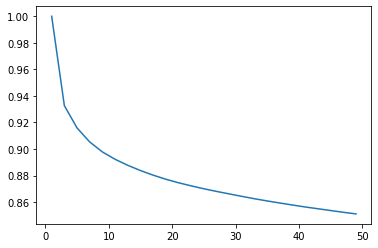

In [0]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

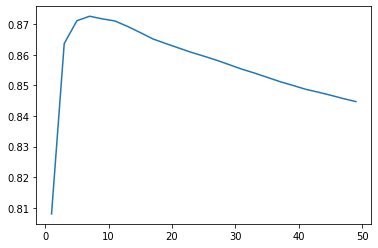

In [0]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

In [0]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 56.07154831829942
median_absolute_error: 4.7735714285714295
r2_score: 0.8687906728428422


In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
  train_sizes= np.linspace(.1,1.0,num=5)
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
   estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std, alpha=0.1,
    color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std, alpha=0.1,
    color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
    label="Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
    label="Cross-validation score")
  plt.legend(loc="best")
  return plt

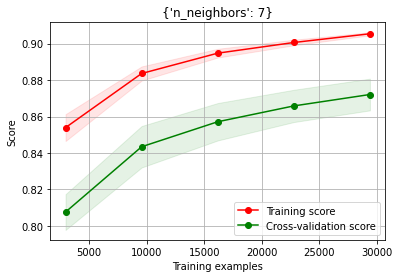

In [0]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
cv=ShuffleSplit(n_splits=10));

In [0]:
def plot_validation_curve(estimator, title, X, y,
param_name, param_range, cv,
scoring="accuracy"):
  train_scores, test_scores = validation_curve(
  estimator, X, y, param_name=param_name,
  param_range=param_range,
  cv=cv, scoring=scoring, n_jobs=-1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.title(title)
  plt.xlabel(param_name)
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.plot(param_range, train_scores_mean, label="Training score",
  color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
  train_scores_mean + train_scores_std, alpha=0.2,
  color="darkorange", lw=lw)
  plt.plot(param_range, test_scores_mean,
  label="Cross-validation score",
  color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
  test_scores_mean + test_scores_std, alpha=0.2,
  color="navy", lw=lw)
  plt.legend(loc="best")
  return plt

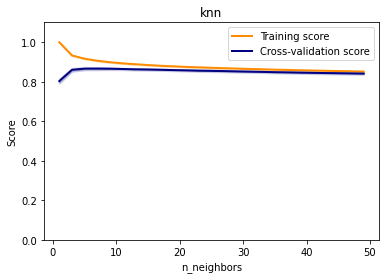

In [0]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y,
  param_name="n_neighbors", param_range=n_range,
  cv=ShuffleSplit(n_splits=10), scoring="r2");